# Case Study in Econometrics and Data Science

### Authors
Rick Geling,
Perry Boer,
...
...

#### Please see 'README.md' for a description of the folder structure.

In [2]:
# Get the standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from matplotlib.collections import PolyCollection
from statsmodels.tsa.stattools import acf, q_stat
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Get the required self-made packages
from data_processing import DataProcessor
from lasso_methods.lasso_estimation import LassoEstimator
from bootstrap_methods.lasso_bootstrap import LassoBootstrap


# 1. ALL DATA

In [4]:
# Load data
processor = DataProcessor()
precip_file = "knmi_monthly_precipitation.csv"
climate_file = "climate_index_data_v4_all.csv"
processor.prepare_data(
    precip_dat=precip_file,
    COI_dat=climate_file,
    start_time="1979-01-01", # ----> TODO: 1950 seems to give worse results...
    end_time="2023-12-31"
)

### 1.1a descriptive stats


In [6]:
# Get precipitation stats
precip_stats = processor.descriptive_stats_precip()
print("Descriptive Statistics for Precipitation Data:")
print(precip_stats)

Descriptive Statistics for Precipitation Data:
                     count     mean      std  min     25%    50%    75%  \
Daily_Precipitation  540.0  700.693  388.687 -8.0  404.75  666.0  914.5   

                        max  
Daily_Precipitation  2195.0  


In [7]:
precip_cols = [col for col in processor.df.columns if 'precip' in col.lower()]
extended_precip_stats = processor.extended_descriptive_stats(precip_cols)
print("Extended Descriptive Statistics for Precipitation Data:")
print(extended_precip_stats)

Extended Descriptive Statistics for Precipitation Data:
                     count     mean      std  min     25%    50%    75%  \
Daily_Precipitation  540.0  700.693  388.687 -8.0  404.75  666.0  914.5   

                        max  skewness  kurtosis  
Daily_Precipitation  2195.0     0.696     0.427  


In [8]:
# Get COI stats
coi_stats = processor.descriptive_stats_coi()
print("Descriptive Statistics for Climate Oscillation Indices:")
print(coi_stats)

Descriptive Statistics for Climate Oscillation Indices:
              count      mean    std      min       25%       50%       75%  \
aao           540.0     0.109  0.984   -3.010    -0.540     0.146     0.774   
amm           540.0     0.320  2.651   -6.480    -1.402     0.330     2.200   
ao.long       540.0     0.014  1.013   -4.266    -0.528    -0.012     0.586   
dmi.had.long  540.0    -0.046  0.341   -1.108    -0.268    -0.068     0.142   
nao.long      540.0    -0.001  1.813   -4.700    -1.240     0.005     1.280   
nina34.anom   540.0    -0.047  0.882   -2.050    -0.653    -0.130     0.462   
noi           540.0    -0.035  2.935  -12.164    -1.562    -0.025     1.474   
np.long       540.0  1012.512  4.576  996.444  1009.745  1013.938  1015.801   
npgo          540.0    -0.155  1.233   -3.371    -1.043    -0.267     0.780   
pdo           540.0    -0.121  1.102   -2.803    -0.958    -0.076     0.675   
pmm           540.0     0.151  3.293   -8.670    -1.810     0.560     2.462

In [9]:
coi_cols = [col for col in processor.df.columns if col not in ['Date'] and 'precip' not in col.lower()]
extended_coi_stats = processor.extended_descriptive_stats(coi_cols)
print("Extended Descriptive Statistics for Climate Oscillation Indices:")
print(extended_coi_stats)

Extended Descriptive Statistics for Climate Oscillation Indices:
              count      mean    std      min       25%       50%       75%  \
aao           540.0     0.109  0.984   -3.010    -0.540     0.146     0.774   
amm           540.0     0.320  2.651   -6.480    -1.402     0.330     2.200   
ao.long       540.0     0.014  1.013   -4.266    -0.528    -0.012     0.586   
dmi.had.long  540.0    -0.046  0.341   -1.108    -0.268    -0.068     0.142   
nao.long      540.0    -0.001  1.813   -4.700    -1.240     0.005     1.280   
nina34.anom   540.0    -0.047  0.882   -2.050    -0.653    -0.130     0.462   
noi           540.0    -0.035  2.935  -12.164    -1.562    -0.025     1.474   
np.long       540.0  1012.512  4.576  996.444  1009.745  1013.938  1015.801   
npgo          540.0    -0.155  1.233   -3.371    -1.043    -0.267     0.780   
pdo           540.0    -0.121  1.102   -2.803    -0.958    -0.076     0.675   
pmm           540.0     0.151  3.293   -8.670    -1.810     0.560 

In [10]:
processor.df

,Date,Daily_Precipitation,aao,amm,ao.long,dmi.had.long,nao.long,nina34.anom,noi,np.long,...,scand,soi.long,tna,tsa,wp,ea,eawr,epnp,pna,poleur
936,1979-01-01,562.0,0.209,1.15,-2.233,0.317,-3.22,-0.13,-3.011,1006.274,...,0.53,-0.45,0.17,-0.16,1.43,-0.98,-0.79,2.12,-1.54,0.71
937,1979-02-01,566.0,0.356,2.50,-0.697,-0.158,-0.62,-0.22,0.203,1014.246,...,0.19,0.61,0.28,-0.24,-0.66,1.28,-0.20,-0.18,-2.73,1.81
938,1979-03-01,970.0,0.899,2.37,-0.814,-0.034,0.54,-0.02,-2.035,1008.151,...,0.75,-0.49,0.15,-0.31,-0.29,-0.94,-0.10,0.83,0.08,-1.87
939,1979-04-01,794.0,0.678,2.16,-1.157,-0.207,-0.79,0.02,-0.973,1015.654,...,0.22,-0.65,0.29,0.01,0.85,-0.63,0.15,0.66,-0.15,0.08
940,1979-05-01,1329.0,0.724,2.42,-0.250,-0.444,1.00,-0.25,-0.271,1013.366,...,-0.38,0.46,0.35,0.07,-0.13,1.45,-0.83,-0.87,1.27,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2023-08-01,958.0,-0.038,2.95,-0.602,0.825,-1.75,1.35,-2.002,1016.050,...,-1.07,-1.60,1.36,0.50,-0.37,2.05,-2.35,-1.16,0.42,-1.05
1472,2023-09-01,523.0,-1.050,5.72,0.318,0.946,-0.65,1.60,-0.299,1015.700,...,-0.25,-1.36,1.43,0.40,1.34,2.72,-2.14,-2.58,0.84,0.78
1473,2023-10-01,2195.0,0.535,5.51,-0.414,0.804,-1.23,1.72,-3.826,1011.689,...,-0.58,-0.60,1.32,0.41,-0.83,1.20,0.61,0.31,1.49,-0.07
1474,2023-11-01,1591.0,0.097,4.00,-0.036,0.920,-0.43,2.02,-3.036,1012.047,...,-0.11,-0.90,1.09,0.91,0.59,1.19,0.13,0.39,0.51,0.30


## 1.1b Preparation and Characterization

In [12]:
# --------------------------------------------------------------------
# Drop columns with missing values
display(processor.df)
# Drop 'epnp' column temporarily
if 'epnp' in processor.df.columns:
    processor.df.drop(columns=['epnp'], inplace=True)
    print("Column 'epnp' removed from the dataset.")
else:
    print("Column 'epnp' not found in the dataset.")
display(processor.df)

# --------------------------------------------------------------------
# Identify COI columns by exclusion
exclude_cols = ["Date", "Daily_Precipitation"]
coi_columns = [col for col in processor.df.columns if col not in exclude_cols]


####################
# so we get from this:
# - processor
# - coi_columns
# - missing_info
# - adf_result_before
# - adf_result_after
# - adf_result for each COI
# - het_results
# - dw

,Date,Daily_Precipitation,aao,amm,ao.long,dmi.had.long,nao.long,nina34.anom,noi,np.long,...,scand,soi.long,tna,tsa,wp,ea,eawr,epnp,pna,poleur
936,1979-01-01,562.0,0.209,1.15,-2.233,0.317,-3.22,-0.13,-3.011,1006.274,...,0.53,-0.45,0.17,-0.16,1.43,-0.98,-0.79,2.12,-1.54,0.71
937,1979-02-01,566.0,0.356,2.50,-0.697,-0.158,-0.62,-0.22,0.203,1014.246,...,0.19,0.61,0.28,-0.24,-0.66,1.28,-0.20,-0.18,-2.73,1.81
938,1979-03-01,970.0,0.899,2.37,-0.814,-0.034,0.54,-0.02,-2.035,1008.151,...,0.75,-0.49,0.15,-0.31,-0.29,-0.94,-0.10,0.83,0.08,-1.87
939,1979-04-01,794.0,0.678,2.16,-1.157,-0.207,-0.79,0.02,-0.973,1015.654,...,0.22,-0.65,0.29,0.01,0.85,-0.63,0.15,0.66,-0.15,0.08
940,1979-05-01,1329.0,0.724,2.42,-0.250,-0.444,1.00,-0.25,-0.271,1013.366,...,-0.38,0.46,0.35,0.07,-0.13,1.45,-0.83,-0.87,1.27,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2023-08-01,958.0,-0.038,2.95,-0.602,0.825,-1.75,1.35,-2.002,1016.050,...,-1.07,-1.60,1.36,0.50,-0.37,2.05,-2.35,-1.16,0.42,-1.05
1472,2023-09-01,523.0,-1.050,5.72,0.318,0.946,-0.65,1.60,-0.299,1015.700,...,-0.25,-1.36,1.43,0.40,1.34,2.72,-2.14,-2.58,0.84,0.78
1473,2023-10-01,2195.0,0.535,5.51,-0.414,0.804,-1.23,1.72,-3.826,1011.689,...,-0.58,-0.60,1.32,0.41,-0.83,1.20,0.61,0.31,1.49,-0.07
1474,2023-11-01,1591.0,0.097,4.00,-0.036,0.920,-0.43,2.02,-3.036,1012.047,...,-0.11,-0.90,1.09,0.91,0.59,1.19,0.13,0.39,0.51,0.30


Column 'epnp' removed from the dataset.


,Date,Daily_Precipitation,aao,amm,ao.long,dmi.had.long,nao.long,nina34.anom,noi,np.long,...,pmm,scand,soi.long,tna,tsa,wp,ea,eawr,pna,poleur
936,1979-01-01,562.0,0.209,1.15,-2.233,0.317,-3.22,-0.13,-3.011,1006.274,...,0.77,0.53,-0.45,0.17,-0.16,1.43,-0.98,-0.79,-1.54,0.71
937,1979-02-01,566.0,0.356,2.50,-0.697,-0.158,-0.62,-0.22,0.203,1014.246,...,-0.59,0.19,0.61,0.28,-0.24,-0.66,1.28,-0.20,-2.73,1.81
938,1979-03-01,970.0,0.899,2.37,-0.814,-0.034,0.54,-0.02,-2.035,1008.151,...,-0.97,0.75,-0.49,0.15,-0.31,-0.29,-0.94,-0.10,0.08,-1.87
939,1979-04-01,794.0,0.678,2.16,-1.157,-0.207,-0.79,0.02,-0.973,1015.654,...,-0.36,0.22,-0.65,0.29,0.01,0.85,-0.63,0.15,-0.15,0.08
940,1979-05-01,1329.0,0.724,2.42,-0.250,-0.444,1.00,-0.25,-0.271,1013.366,...,-0.69,-0.38,0.46,0.35,0.07,-0.13,1.45,-0.83,1.27,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2023-08-01,958.0,-0.038,2.95,-0.602,0.825,-1.75,1.35,-2.002,1016.050,...,-6.17,-1.07,-1.60,1.36,0.50,-0.37,2.05,-2.35,0.42,-1.05
1472,2023-09-01,523.0,-1.050,5.72,0.318,0.946,-0.65,1.60,-0.299,1015.700,...,-5.27,-0.25,-1.36,1.43,0.40,1.34,2.72,-2.14,0.84,0.78
1473,2023-10-01,2195.0,0.535,5.51,-0.414,0.804,-1.23,1.72,-3.826,1011.689,...,-4.26,-0.58,-0.60,1.32,0.41,-0.83,1.20,0.61,1.49,-0.07
1474,2023-11-01,1591.0,0.097,4.00,-0.036,0.920,-0.43,2.02,-3.036,1012.047,...,-4.00,-0.11,-0.90,1.09,0.91,0.59,1.19,0.13,0.51,0.30


In [13]:
# --------------------------------------------------------------------
# Test stationarity (ADF) for raw data (before normalization/standardization)

# Test for precipitation
adf_result_precip = processor.stationarity_tester(processor.df["Daily_Precipitation"])
print("Stationarity test for raw precipitation data:", adf_result_precip)

# Test for COIs
print("\nStationarity Test Results for Raw COIs:")
for coi in coi_columns:
    if coi in processor.df.columns:
        adf_result = processor.stationarity_tester(processor.df[coi])
        print(f"\n{coi.upper()} Stationarity Test:")
        print(f"  Test Statistic: {adf_result['test_statistic']:.3f}")
        print(f"  p-Value: {adf_result['p_value']:.3f}")
        print(f"  Critical Values: {adf_result['critical_values']}")
        print(f"  Stationary: {'Yes' if adf_result['is_stationary_at_alpha'] else 'No'}")
    else:
        print(f"  {coi} not found in the DataFrame.")

Stationarity test for raw precipitation data: {'test_statistic': -21.992006072793227, 'p_value': 0.0, 'used_lag': 0, 'num_obs': 539, 'critical_values': {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}, 'is_stationary_at_alpha': True}

Stationarity Test Results for Raw COIs:

AAO Stationarity Test:
  Test Statistic: -9.688
  p-Value: 0.000
  Critical Values: {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}
  Stationary: Yes

AMM Stationarity Test:
  Test Statistic: -4.077
  p-Value: 0.001
  Critical Values: {'1%': -3.442843345332837, '5%': -2.867050445147657, '10%': -2.5697048674984457}
  Stationary: Yes

AO.LONG Stationarity Test:
  Test Statistic: -16.896
  p-Value: 0.000
  Critical Values: {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}
  Stationary: Yes

DMI.HAD.LONG Stationarity Test:
  Test Statistic: -7.190
  p-Value: 0.000
  Critical Values: {'1%': -3.442563336759378, '5%': -2.

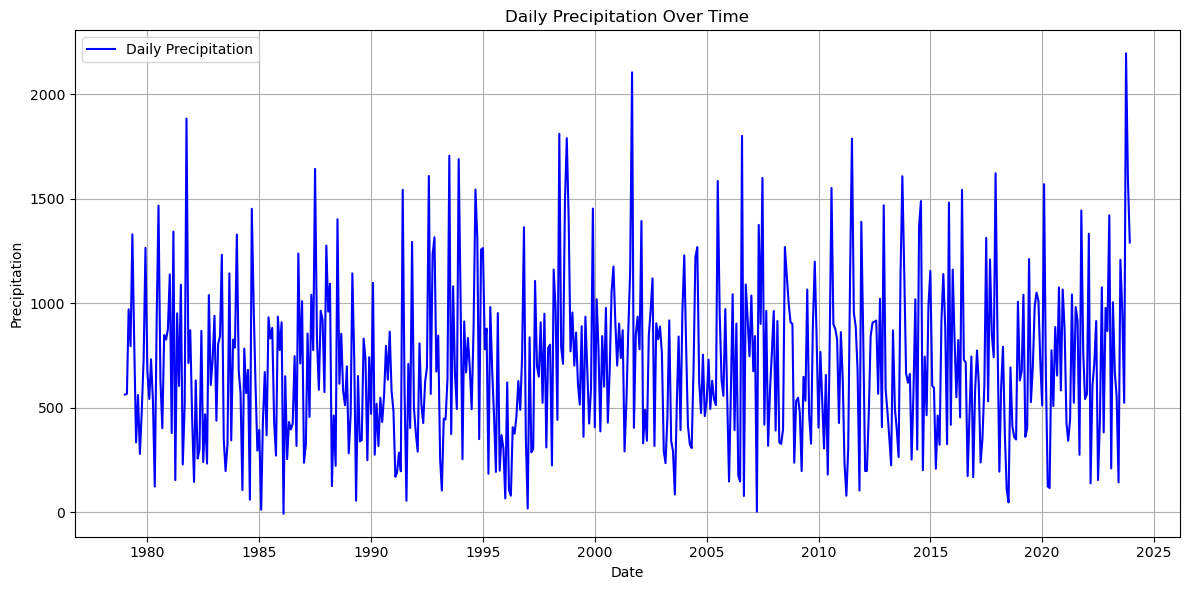

In [14]:
# --------------------------------------------------------------------
# plot the raw data for precipitation and COIs

# Plot precipitation
# plt.figure(figsize=(12, 6))

# plt.plot(processor.df["Date"], processor.df["Daily_Precipitation"], label="Daily Precipitation")

processor.plot_precip_or_cois(plot_type="precip")


In [15]:
# --------------------------------------------------------------------
# Standardize COI data (after stationarity check)
processor.standardize_COI_data(coi_columns)
# Save the old (non-standardized) COIs for comparison
# processor.df["non_standardized_COIs"] = processor.df[coi_columns] #TODO: check if this works


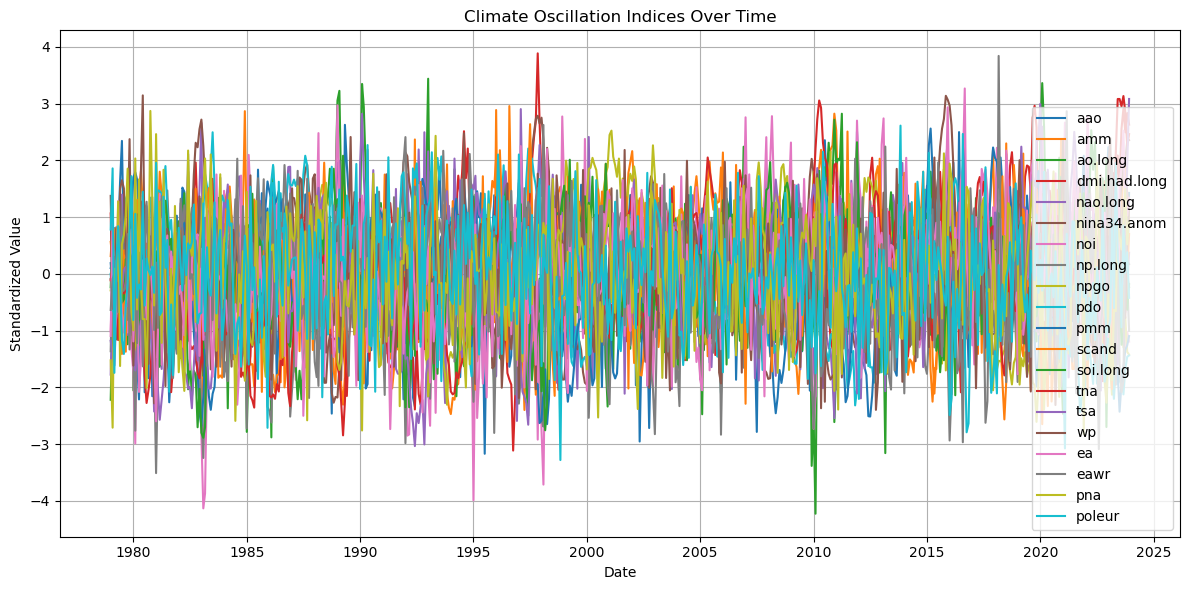

In [16]:
# # Plot COIs
processor.plot_precip_or_cois(plot_type="cois")

In [17]:
# --------------------------------------------------------------------
# 5. Check for missing values and summarize
all_columns = processor.df.columns.tolist()
missing_info = processor.check_missing_values(columns=all_columns)
print("Missing value summary:\n", missing_info)

Missing value summary:
             column_name  num_missing  pct_missing
0                  Date            0          0.0
1   Daily_Precipitation            0          0.0
2                   aao            0          0.0
3                   amm            0          0.0
4               ao.long            0          0.0
5          dmi.had.long            0          0.0
6              nao.long            0          0.0
7           nina34.anom            0          0.0
8                   noi            0          0.0
9               np.long            0          0.0
10                 npgo            0          0.0
11                  pdo            0          0.0
12                  pmm            0          0.0
13                scand            0          0.0
14             soi.long            0          0.0
15                  tna            0          0.0
16                  tsa            0          0.0
17                   wp            0          0.0
18                   ea   

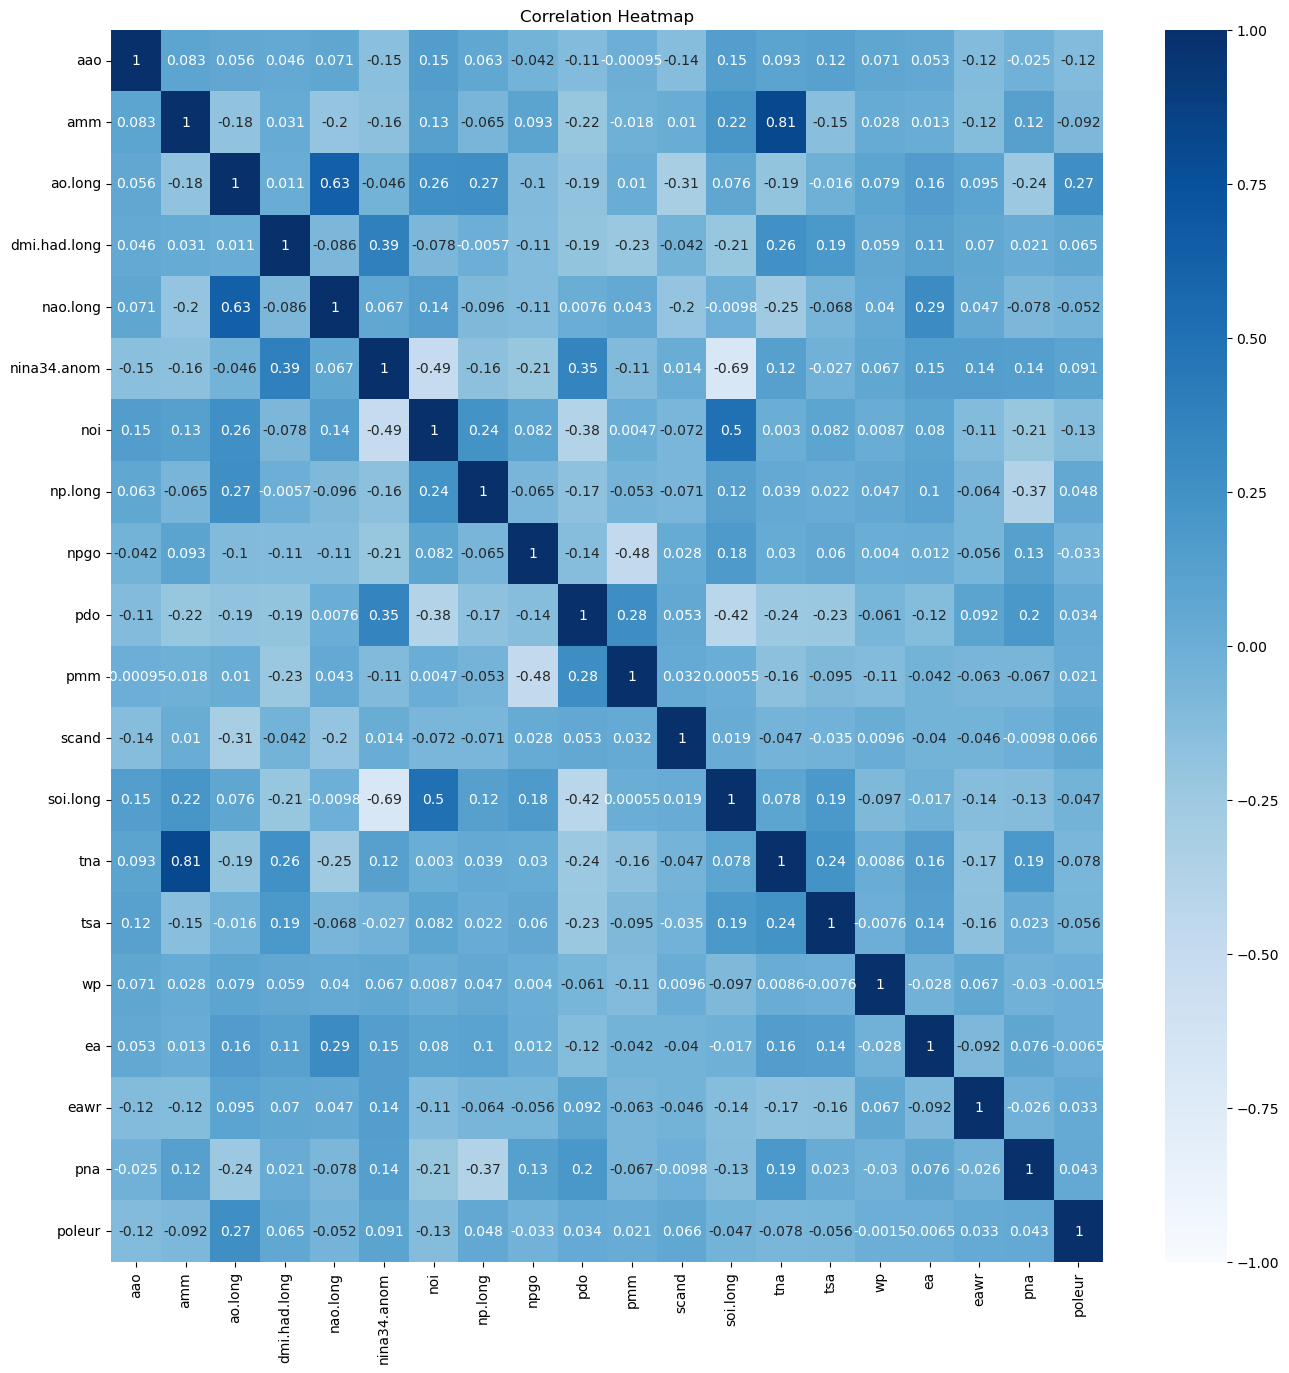

In [18]:
# --------------------------------------------------------------------
# 6. Make a correlation heatmap
processor.plot_correlation_heatmap(columns=coi_columns)

In [19]:
# --------------------------------------------------------------------
# 7. Remove seasonality in precipitation
processor.remove_seasonality_precip(
    date_col="Date",
    precip_col="Daily_Precipitation"
)
# After seasonality removal, 'precip_anomaly' is created

#TODO: STANDARDIZE THE PRECIP ANOMALY IF WE LIKE


In [20]:
# --------------------------------------------------------------------
# 8. Test stationarity for precipitation anomaly
adf_result_anomaly = processor.stationarity_tester(processor.df["precip_anomaly"])
print("Stationarity test for precipitation anomaly:", adf_result_anomaly)


Stationarity test for precipitation anomaly: {'test_statistic': -23.119592126376975, 'p_value': 0.0, 'used_lag': 0, 'num_obs': 539, 'critical_values': {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}, 'is_stationary_at_alpha': True}


In [21]:
# test stationarity for COIs
print("\nStationarity Test Results for Standardized COIs:")

for coi in coi_columns:
    if coi in processor.df.columns:
        adf_result = processor.stationarity_tester(processor.df[coi])
        print(f"\n{coi.upper()} Stationarity Test:")
        print(f"  Test Statistic: {adf_result['test_statistic']:.6f}")
        print(f"  p-Value: {adf_result['p_value']:.6f}")
        print(f"  Critical Values: {adf_result['critical_values']}")
        print(f"  Stationary: {'Yes' if adf_result['is_stationary_at_alpha'] else 'No'}")
    else:
        print(f"  {coi} not found in the DataFrame.")


Stationarity Test Results for Standardized COIs:

AAO Stationarity Test:
  Test Statistic: -9.687633
  p-Value: 0.000000
  Critical Values: {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}
  Stationary: Yes

AMM Stationarity Test:
  Test Statistic: -4.076531
  p-Value: 0.001059
  Critical Values: {'1%': -3.442843345332837, '5%': -2.867050445147657, '10%': -2.5697048674984457}
  Stationary: Yes

AO.LONG Stationarity Test:
  Test Statistic: -16.895988
  p-Value: 0.000000
  Critical Values: {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432333636}
  Stationary: Yes

DMI.HAD.LONG Stationarity Test:
  Test Statistic: -7.189835
  p-Value: 0.000000
  Critical Values: {'1%': -3.442563336759378, '5%': -2.866927190004947, '10%': -2.5696391843672695}
  Stationary: Yes

NAO.LONG Stationarity Test:
  Test Statistic: -19.452340
  p-Value: 0.000000
  Critical Values: {'1%': -3.4425405682241816, '5%': -2.8669171671779816, '10%': -2.5696338432

In [22]:
# --------------------------------------------------------------------
# 9. Test heteroskedasticity (example: regress Precip on some COIs)
test_cols = ["nao.long", "tna"]  # just as an example
het_results = processor.heteroskedasticity_tester(
    y_col="precip_anomaly",
    x_cols=coi_columns  # Or specific test columns
)
print("\nHeteroskedasticity test results:", het_results)



Heteroskedasticity test results: {'Breusch-Pagan_Statistic': 26.139015308180483, 'Breusch-Pagan_pvalue': 0.1612695622741009, 'White_Test_Statistic': 256.8055213885833, 'White_Test_pvalue': 0.1083939938186625}


In [23]:
# --------------------------------------------------------------------
# 10. Test serial correlation (Durbin-Watson)
dw = processor.serial_correlation_tester(
    y_col="precip_anomaly",
    x_cols=coi_columns  # Or specific test columns
)
print(f"\nDurbin-Watson statistic = {dw:.3f} (2 ~ no autocorrelation)")


Durbin-Watson statistic = 2.041 (2 ~ no autocorrelation)


## 1.1b Extra analysis preparation and characterization [INPUT DATA ANALYSIS, PLOTTING ETC HERE]

## 1.2a. LASSO & Bootstrapping function

In [26]:
def perform_LASSOs_and_bootstraps(y_col, all_coi_cols, related_processor):
    """
    Demonstrates how to call run_lasso() plus the new LassoBootstrap
    for 'modified_wild_bootstrap', in 3 scenarios:
      1) manual alpha=0.1, no CV, no lags
      2) CV alpha, no lags
      3) CV alpha, lags=3
    """

    estimator = LassoEstimator(random_state=2023)
    bootstrapper = LassoBootstrap(estimator)

    # 1) manual alpha=0.1, no CV, no lags
    print("--- manual alpha=0.1, no CV, no lags ---")
    results_manual_lasso = estimator.run_lasso(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha=0.1,
        use_cv=False,
        max_lag=0
    )
    results_manual_modwild = bootstrapper.modified_wild_bootstrap(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha_val=0.1,
        use_cv=False,
        max_lag=0,
        B=200,
        threshold=0.01,
        random_state=123
    )

    # 2) CV alpha, no lags
    print("\n--- CV alpha, no lags ---")
    results_cv_lasso = estimator.run_lasso(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha=None,
        use_cv=True,  # LassoCV
        max_lag=0
    )
    results_cv_modwild = bootstrapper.modified_wild_bootstrap(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha_val=None,
        use_cv=True,
        max_lag=0,
        B=200,
        threshold=0.01,
        random_state=123
    )

    # 3) CV alpha, lags=3
    print("\n--- CV alpha, lags=3 ---")
    results_lags_lasso = estimator.run_lasso(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha=None,
        use_cv=True,
        max_lag=6
    )
    results_lags_modwild = bootstrapper.modified_wild_bootstrap(
        df=related_processor.df,
        y_col=y_col,
        x_cols=all_coi_cols,
        alpha_val=None,
        use_cv=True,
        max_lag=6,
        B=200,
        threshold=0.01,
        random_state=123
    )

    return (
        results_manual_lasso,
        results_manual_modwild,
        results_cv_lasso,
        results_cv_modwild,
        results_lags_lasso,
        results_lags_modwild
    )


## 1.2b Analyse all LASSO and bootstrap output

In [28]:
# --------------------------------------------------------------------
# 11. LASSO Analysis for ALL DATA
# --------------------------------------------------------------------

# define y_col and call function
y_col = "precip_anomaly"

(
    results_manual_lasso,
    results_manual_modwild,
    results_cv_lasso,
    results_cv_modwild,
    results_lags_lasso,
    results_lags_modwild
) = perform_LASSOs_and_bootstraps(
    y_col,
    coi_columns,
    processor,
)


# # DO ANALYSIS:
# # (c) example 1: LASSO with a manually specified alpha
# print("\n--- LASSO (Manual alpha) with ALL COIs ---")
# print(f"Chosen alpha: {results_manual_lasso['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_manual_lasso["coefficients"].sort_values(key=abs, ascending=False).head(10))
# print(f"Intercept: {results_manual_lasso['intercept']:.3f}")
# print(f"R^2: {results_manual_lasso['r2_score']:.3f}")

# # mow do bootstrap with the same alpha=alpha_value
# print("\n--- Wild Bootstrap after Manual Alpha Fit ---")
# print("Original Coefficients:\n", results_manual_modwild["original_coefs"])
# print("Mean of Bootstrapped Coefficients:\n", results_manual_modwild["coefs_mean"])
# print("5th Percentile:\n", results_manual_modwild["coefs_percentiles"][5])
# print("95th Percentile:\n", results_manual_modwild["coefs_percentiles"][95])



# # (d) Example 2: LASSO with cross-validation to find alpha
# print("\n--- LASSO (CV) with ALL COIs ---")
# print(f"Optimal alpha: {results_cv_lasso['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_cv_lasso["coefficients"].sort_values(key=abs, ascending=False).head(30))
# print(f"Intercept: {results_cv_lasso['intercept']:.3f}")
# print(f"R^2: {results_cv_lasso['r2_score']:.3f}")

# # (e) Example 3: LASSO with lags
# print("\n--- LASSO (with Lags + CV) with ALL COIs ---")
# print(f"Optimal alpha: {results_lags_lasso['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_lags_lasso["coefficients"].sort_values(key=abs, ascending=False).head(10))
# print(f"Intercept: {results_lags_lasso['intercept']:.3f}")
# print(f"R^2: {results_lags_lasso['r2_score']:.3f}")
# print(f"Number of columns after lagging: {len(results_lags_lasso['lagged_columns'])}")


--- manual alpha=0.1, no CV, no lags ---

--- CV alpha, no lags ---

--- CV alpha, lags=3 ---


In [29]:
results_cv_lasso

{'alpha': 15.751459665389223,
 'coefficients': array([  0.        ,   0.        ,  -0.        ,   0.        ,
          0.        ,   2.98783894,  -0.        ,  -1.7277221 ,
         -0.        ,  -0.        , -18.3121275 ,  -0.        ,
         -4.41716426,   6.01203856,  -0.        ,  13.99279937,
         36.90378183, -61.12843349,   2.34071711, -13.01839474]),
 'intercept': -3.5425883534819872e-15,
 'r2_score': 0.08327143345140642,
 'residuals': array([-1.65830822e+02, -2.79620843e+01,  3.55393124e+02,  3.89276277e+02,
         6.38686021e+02,  1.55912591e+02, -5.19962195e+02, -2.05914233e+02,
        -4.60969945e+02, -3.20083091e+02, -1.74520135e+02,  4.70606496e+02,
         5.67557039e+01, -5.97708192e+00,  3.63999539e+01,  1.91252490e+02,
        -4.33029890e+02,  1.16226910e+02,  6.76146827e+02,  2.42693350e+01,
        -3.31101329e+02, -2.21405946e+01,  1.14125843e+02,  7.36812329e+01,
         5.65919762e+02, -2.04128447e+02,  7.00553986e+02, -1.43442419e+02,
         3.730

In [30]:
results_lags_lasso

{'alpha': 20.96041930423764,
 'coefficients': array([  0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,   0.        , -10.31876052,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,   0.        ,
         -0.        ,   0.        ,   0.        ,   0.        ,
          0.45679872,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  12.43487942,   3.60245622,
          0.        ,   0.        ,  -0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.        ,  -0.        ,
         -0.        ,   0.        ,   0.        ,  -0.        ,
          0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -0.        ,   0.        ,   0.        ,
         -0.        ,  -0.        ,  -0.        ,  -0.     

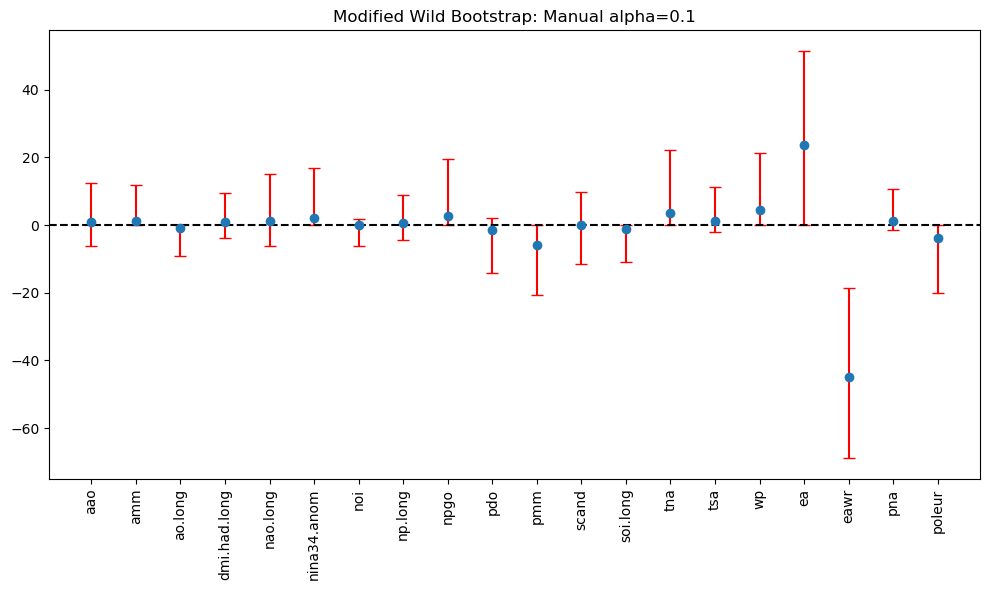

In [31]:
def plot_bootstrap_coefs(boot_res, x_cols=None, title="Bootstrap Coefficients"):
    """
    Plots mean coefficient with error bars for [5%,95%].
    boot_res: dict from the bootstrap. 
              expects "coefs_mean" and "coefs_percentiles" and "thresholded_coefs"
    x_cols: optional list of predictor names. If None, we just label them 1..p
    """

    #NOTE: DOES NOT WORK WITH LAGS (YET)
    
    coefs_mean = boot_res["coefs_mean"]
    low_5 = boot_res["coefs_percentiles"][5]
    hi_95 = boot_res["coefs_percentiles"][95]

    p = len(coefs_mean)
    if x_cols is None:
        x_cols = [f"coef_{i}" for i in range(p)]

    # Create a data structure for plotting
    df_plot = pd.DataFrame({
        "predictor": x_cols,
        "mean_coef": coefs_mean,
        "lower": low_5,
        "upper": hi_95
    })
    df_plot["x_idx"] = range(p)

    plt.figure(figsize=(10,6))
    plt.errorbar(df_plot["x_idx"], df_plot["mean_coef"],
                 yerr=[df_plot["mean_coef"] - df_plot["lower"],
                       df_plot["upper"] - df_plot["mean_coef"]],
                 fmt='o', ecolor='red', capsize=4)
    plt.axhline(y=0, color="black", linestyle="--")
    plt.xticks(df_plot["x_idx"], df_plot["predictor"], rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_bootstrap_coefs(
    boot_res=results_cv_modwild, 
    x_cols=coi_columns, 
    title="Modified Wild Bootstrap: Manual alpha=0.1"
)

# 2. SEASONAL DATA: Winter

## 2.1a Seasonal data: Prepare and Characterize

In [34]:
# Now, we move into seasonal stuff! --> Winter 
seasons_dict = processor.season_splitter(date_col="Date")
df_djf = seasons_dict["winter"]

# 1) Create a new DataProcessor for winter
winter_processor = DataProcessor()
winter_processor.df = df_djf.copy()  # pass the DJF subset

print("\n=== WINTER DATA (DJF) ANALYSIS ===")

# 3) Stationarity Test on the winter precipitation column
#    (Either "Daily_Precipitation" or "precip_anomaly" if you removed seasonality)
y_winter_col = "precip_anomaly"#"Daily_Precipitation"  # or "precip_anomaly"
adf_result_winter = winter_processor.stationarity_tester(winter_processor.df[y_winter_col])
print("Stationarity test (Winter Precip):", adf_result_winter)

# 4) Test stationarity on COIs in winter
#    Identify the COI columns for winter
exclude_cols = ["Date", "Daily_Precipitation", "precip_anomaly", "month"]
coi_winter = [c for c in winter_processor.df.columns if c not in exclude_cols]
print("\nStationarity Test Results for Winter COIs:")
for coi in coi_winter:
    adf_res = winter_processor.stationarity_tester(winter_processor.df[coi])
    print(f"  {coi} => p-value: {adf_res['p_value']:.3f}, Stationary? {adf_res['is_stationary_at_alpha']}")

# 5) Heteroskedasticity Test
#    We can do a quick check, using the same approach as before
het_winter = winter_processor.heteroskedasticity_tester(
    y_col=y_winter_col, 
    x_cols=coi_winter
)
print("\nHeteroskedasticity test results (Winter):", het_winter)

# 6) Serial Correlation (Durbin-Watson)
dw_winter = winter_processor.serial_correlation_tester(
    y_col=y_winter_col,
    x_cols=coi_winter
)
print(f"\nDurbin-Watson (Winter) = {dw_winter:.3f} (2 ~ no autocorr)")



=== WINTER DATA (DJF) ANALYSIS ===
Stationarity test (Winter Precip): {'test_statistic': -11.016935007403728, 'p_value': 6.123185765362769e-20, 'used_lag': 0, 'num_obs': 134, 'critical_values': {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}, 'is_stationary_at_alpha': True}

Stationarity Test Results for Winter COIs:
  aao => p-value: 0.000, Stationary? True
  amm => p-value: 0.010, Stationary? True
  ao.long => p-value: 0.000, Stationary? True
  dmi.had.long => p-value: 0.000, Stationary? True
  nao.long => p-value: 0.000, Stationary? True
  nina34.anom => p-value: 0.000, Stationary? True
  noi => p-value: 0.000, Stationary? True
  np.long => p-value: 0.000, Stationary? True
  npgo => p-value: 0.162, Stationary? False
  pdo => p-value: 0.001, Stationary? True
  pmm => p-value: 0.000, Stationary? True
  scand => p-value: 0.000, Stationary? True
  soi.long => p-value: 0.000, Stationary? True
  tna => p-value: 0.001, Stationary? True
  tsa => p-value: 0.

## 2.1b Extra analysis preparation and characterization [INPUT DATA ANALYSIS, PLOTTING ETC HERE]

In [36]:

## make some plots
## check more descriptive stats


## 2.2. Analyse LASSO and Bootstrap

In [38]:

# perform lasso and bootstrap
(
    results_manual_lasso_winter,
    results_manual_modwild_winter,
    results_cv_lasso_winter,
    results_cv_modwild_winter,
    results_lags_lasso_winter,
    results_lags_modwild_winter,
) = perform_LASSOs_and_bootstraps(
    y_winter_col,
    coi_winter,
    winter_processor
)



# # 7a) Manual alpha
# print("\n--- LASSO (Manual alpha) for WINTER ---")
# print(f"Chosen alpha: {results_manual_lasso_winter['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_manual_lasso_winter["coefficients"].sort_values(key=abs, ascending=False).head(50))
# print(f"Intercept: {results_manual_lasso_winter['intercept']:.3f}")
# print(f"R^2: {results_manual_lasso_winter['r2_score']:.3f}")

# # 7b) LASSO with Cross-Validation
# print("\n--- LASSO (CV) for WINTER ---")
# print(f"Optimal alpha: {results_cv_lasso_winter['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_cv_lasso_winter["coefficients"].sort_values(key=abs, ascending=False).head(20))
# print(f"Intercept: {results_cv_lasso_winter['intercept']:.3f}")
# print(f"R^2: {results_cv_lasso_winter['r2_score']:.3f}")

# # 7c) LASSO with Lags
# print("\n--- LASSO (with Lags + CV) for WINTER ---")
# print(f"Optimal alpha: {results_lags_lasso_winter['alpha']}")
# print("Coefficients (top 10 shown):")
# print(results_lags_lasso_winter["coefficients"].sort_values(key=abs, ascending=False).head(50))
# print(f"Intercept: {results_lags_lasso_winter['intercept']:.3f}")
# print(f"R^2: {results_lags_lasso_winter['r2_score']:.3f}")
# print(f"Number of columns after lagging: {len(results_lags_lasso_winter['lagged_columns'])}")

--- manual alpha=0.1, no CV, no lags ---

--- CV alpha, no lags ---

--- CV alpha, lags=3 ---


C:\Users\archi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e+03, tolerance: 1.314e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\archi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e+03, tolerance: 1.314e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\archi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e+03, toleranc

In [39]:
results_cv_lasso_winter

{'alpha': 6.2117459962861705,
 'coefficients': array([  60.68900519,   -0.        ,  -42.52709902,   20.25191008,
         156.64557778,   -0.        ,  -36.22962495,   -0.        ,
           0.        ,  -40.39191094,   10.56396225,  -59.53329568,
         -14.29368809,   29.30405852,    0.        ,   34.08138364,
          23.67879965, -168.9045942 ,   63.30377114,   10.84353787]),
 'intercept': -62.02191261724404,
 'r2_score': 0.5153215158176339,
 'residuals': array([   9.54161395,  185.26408667,  470.46630248,  298.71069146,
        -204.67518407,  -40.49806265,  268.60699835, -309.17195034,
         -75.48643428,   14.58623574, -141.77442648, -100.76569901,
          67.07965906,   15.1621326 , -218.64363496,  391.05713309,
         -54.59013408,  -75.93885821,  -33.48872063, -179.62594031,
         -35.42201408,    7.64071104,  -61.10756633,  178.75329358,
         -54.87811246, -216.49434011, -123.80114581,  424.29956515,
         212.68768996,  -91.25892544, -215.39415121, -21

In [40]:
results_cv_modwild_winter

{'original_coefs': array([  60.68900519,   -0.        ,  -42.52709902,   20.25191008,
         156.64557778,   -0.        ,  -36.22962495,   -0.        ,
           0.        ,  -40.39191094,   10.56396225,  -59.53329568,
         -14.29368809,   29.30405852,    0.        ,   34.08138364,
          23.67879965, -168.9045942 ,   63.30377114,   10.84353787]),
 'thresholded_coefs': array([  60.68900519,    0.        ,  -42.52709902,   20.25191008,
         156.64557778,    0.        ,  -36.22962495,    0.        ,
           0.        ,  -40.39191094,   10.56396225,  -59.53329568,
         -14.29368809,   29.30405852,    0.        ,   34.08138364,
          23.67879965, -168.9045942 ,   63.30377114,   10.84353787]),
 'original_intercept': -62.02191261724404,
 'boot_coefs': array([[  56.25140629,   -3.59046471,   -2.87419723, ..., -131.3665663 ,
           78.3080969 ,  -13.43023157],
        [  78.06968487,   -0.        ,   10.82138496, ..., -198.0488589 ,
           78.88893106,   -0.   

### Heteroscadasticity and Autocorrelation Test on Residuals & Raw Data

In [42]:
resid = np.array(results_cv_lasso_winter['residuals'])

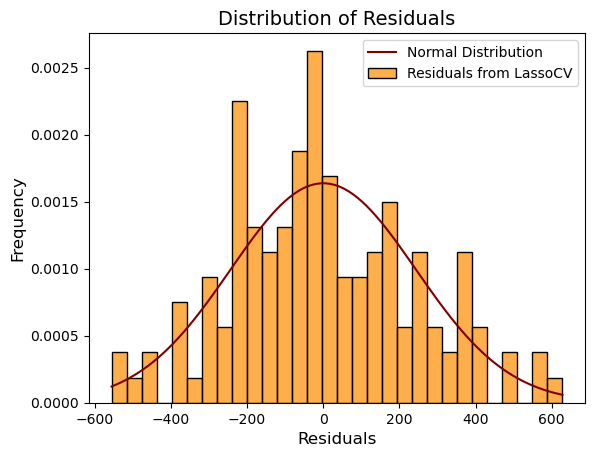

In [43]:
# Generating a normal distribution
mean_residuals = np.mean(resid)
std_residuals = np.std(resid)
x_vals = np.linspace(resid.min(), resid.max(), 100)
normal_pdf = norm.pdf(x_vals, loc=mean_residuals, scale=std_residuals)

sns.histplot(resid, bins=30, kde=False, stat="density", color='darkorange', alpha=0.7, label='Residuals from LassoCV')
plt.plot(x_vals, normal_pdf, color='maroon', label='Normal Distribution')

plt.title('Distribution of Residuals', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

### Heteroskedasticity test

In [45]:
het_winter = winter_processor.heteroskedasticity_tester(
    y_col=y_winter_col, 
    x_cols=coi_winter
)
print("\nHeteroskedasticity test results (Winter):", het_winter)


Heteroskedasticity test results (Winter): {'Breusch-Pagan_Statistic': 25.340609907861225, 'Breusch-Pagan_pvalue': 0.1887095243829983, 'White_Test_Statistic': 135.0, 'White_Test_pvalue': 0.45951888044828637}


### Autocorrelation Test

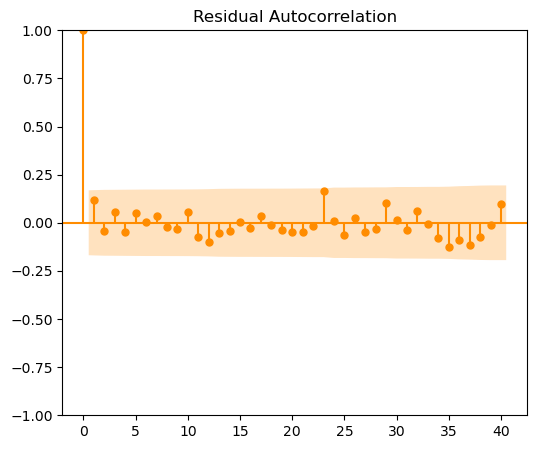

In [47]:
curr_fig, curr_ax = plt.subplots(figsize=(6, 5))
my_color="darkorange"
sm.graphics.tsa.plot_acf(resid, lags=40, ax=curr_ax, color=my_color, vlines_kwargs={"colors": my_color})
for item in curr_ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)
plt.title("Residual Autocorrelation")
plt.show()

In [48]:
# Raw Data

In [49]:
def check_autocorrelation(data, significance_level=0.5, max_lag=20):
    autocorr_results = {}

    for col in data.columns:
        series = data[col]
        
        # Compute ACF and Q-statistics
        acf_values, confint = acf(series, nlags=max_lag, alpha=0.05)

        sig = []
        for i in list(acf_values):
            if i > significance_level:
                sig.append(list(acf_values).index(i))
            

        # Check if there are significant lags
        if len(sig) > 1:
            print(f"'{col}' is autocorrelated up to lags: {sig}")
            #autocorr_results[col] = sig
        else:
            print(f"'{col}' shows no significant autocorrelation.")
            #autocorr_results[col] = []

    return ''

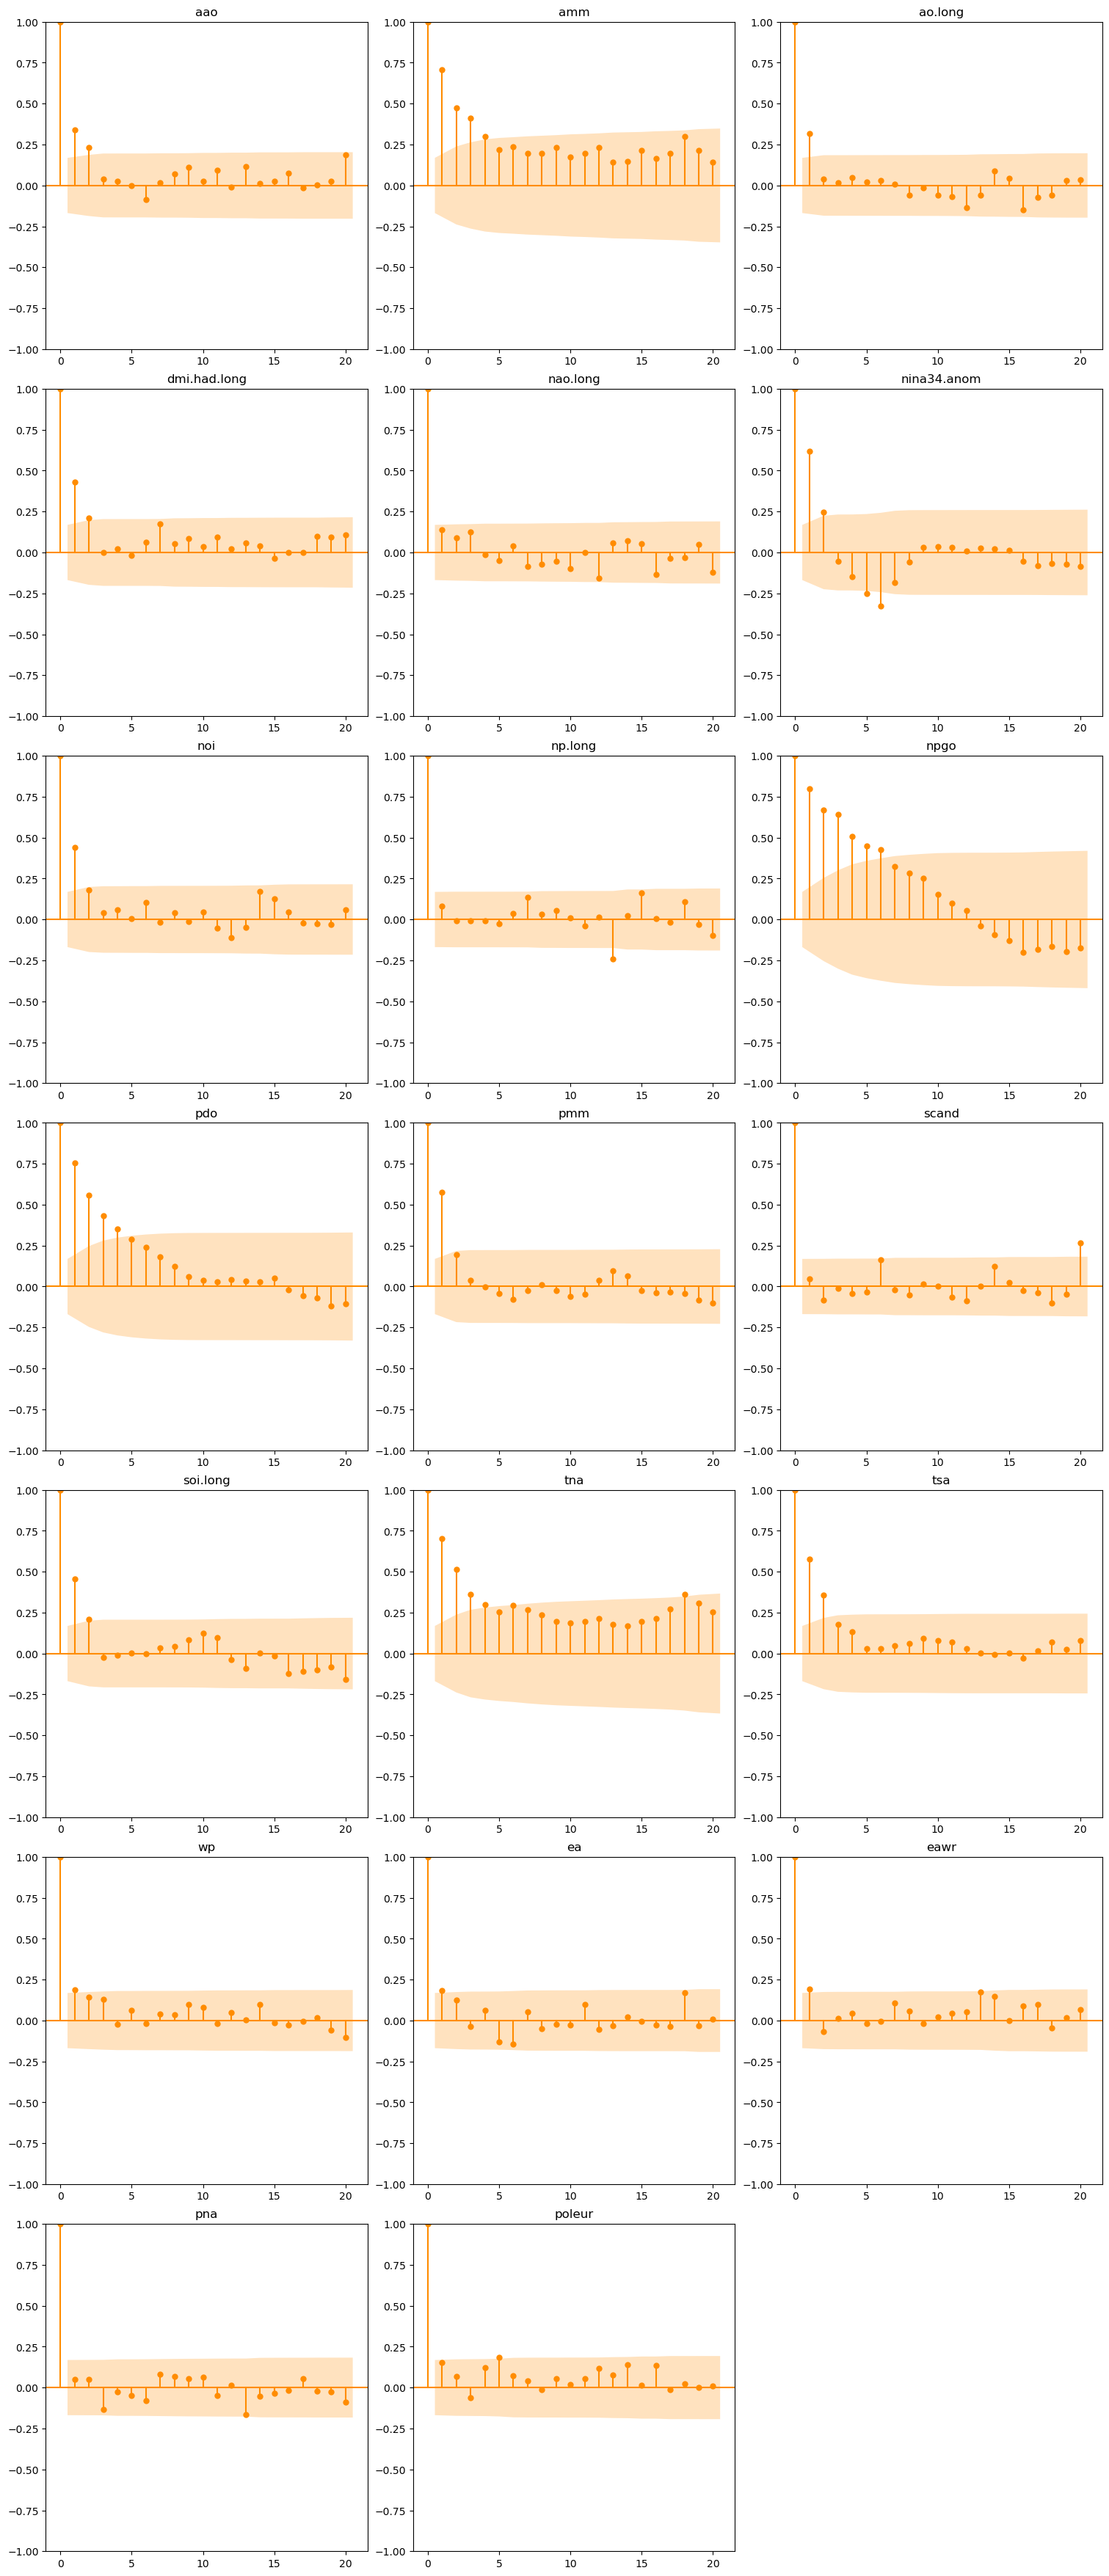

In [50]:
columns = coi_winter  # List of column names
num_plots = len(columns)

# Create subplots: Adjust the number of rows and columns for your layout
rows = (num_plots // 3) + (num_plots % 3 > 0)  # 3 plots per row
cols = 3  # Adjust columns per row
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D axes array for easy indexing

my_color = 'darkorange'

# Generate each plot
for idx, col in enumerate(columns):
    curr_ax = axes[idx]
    plot_acf(winter_processor.df[col], lags=20, ax=curr_ax, color=my_color, vlines_kwargs={"colors": my_color})
    
    # Customize bar colors
    for item in curr_ax.collections:
        if isinstance(item, PolyCollection):
            item.set_facecolor(my_color)
    
    curr_ax.set_title(col, fontsize=12)

# Hide empty subplots if any
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])

# Show the final plot
plt.show()


In [51]:
print(check_autocorrelation(winter_processor.df[columns]))

'aao' shows no significant autocorrelation.
'amm' is autocorrelated up to lags: [0, 1]
'ao.long' shows no significant autocorrelation.
'dmi.had.long' shows no significant autocorrelation.
'nao.long' shows no significant autocorrelation.
'nina34.anom' is autocorrelated up to lags: [0, 1]
'noi' shows no significant autocorrelation.
'np.long' shows no significant autocorrelation.
'npgo' is autocorrelated up to lags: [0, 1, 2, 3, 4]
'pdo' is autocorrelated up to lags: [0, 1, 2]
'pmm' is autocorrelated up to lags: [0, 1]
'scand' shows no significant autocorrelation.
'soi.long' shows no significant autocorrelation.
'tna' is autocorrelated up to lags: [0, 1, 2]
'tsa' is autocorrelated up to lags: [0, 1]
'wp' shows no significant autocorrelation.
'ea' shows no significant autocorrelation.
'eawr' shows no significant autocorrelation.
'pna' shows no significant autocorrelation.
'poleur' shows no significant autocorrelation.



### Bootstrapping

In [53]:
def moving_block_bootstrap_lasso(X, y, block_size, num_bootstrap, alpha=0.05, lasso_alpha=1.0):
    n = X.shape[0]
    num_blocks = n - block_size + 1  # Total number of overlapping blocks
    
    # Create overlapping blocks
    blocks_X = np.array([X[i:i + block_size] for i in range(num_blocks)])
    blocks_y = np.array([y[i:i + block_size] for i in range(num_blocks)])
    
    coefficients = []
    r_squared_values = []  # To store R^2 values for each bootstrap iteration
    
    for _ in range(num_bootstrap):
        # Sample blocks with replacement
        sampled_indices = np.random.choice(num_blocks, size=n // block_size + 1, replace=True)
        X_bootstrap = np.vstack(blocks_X[sampled_indices])[:n]
        y_bootstrap = np.hstack(blocks_y[sampled_indices])[:n]
    
        # Fit Lasso regression with specified alpha
        model = Lasso(alpha=lasso_alpha, random_state=42).fit(X_bootstrap, y_bootstrap)
        coefficients.append(model.coef_)
        
        # Calculate R^2 value and store it
        y_pred = model.predict(X_bootstrap)
        r_squared = r2_score(y_bootstrap, y_pred)
        r_squared_values.append(r_squared)
    
    coefficients = np.array(coefficients)
    r_squared_values = np.array(r_squared_values)
    
    # Calculate mean coefficients
    coefficients_mean = coefficients.mean(axis=0)
    
    # Calculate confidence intervals
    lower_bound = np.percentile(coefficients, 100 * (alpha / 2), axis=0)
    upper_bound = np.percentile(coefficients, 100 * (1 - alpha / 2), axis=0)
    confidence_intervals = np.vstack((lower_bound, upper_bound)).T
    
    # Calculate mean R^2 value
    mean_r_squared = r_squared_values.mean()
    y_predicted_mean = y_predicted_all / num_bootstrap
    
    return coefficients_mean, confidence_intervals, mean_r_squared, y_predicted_mean, y


# def moving_block_bootstrap_lasso(X, y, block_size, num_bootstrap, alpha=0.05, lasso_alpha=1.0):
#     n = X.shape[0]
#     num_blocks = n - block_size + 1  # Total number of overlapping blocks

#     # Create overlapping blocks
#     blocks_X = np.array([X[i:i + block_size] for i in range(num_blocks)])
#     blocks_y = np.array([y[i:i + block_size] for i in range(num_blocks)])

#     coefficients = []
#     r_squared_values = []  # To store R^2 values for each bootstrap iteration
#     y_predicted_all = np.zeros(n)  # Array to store the predicted values

#     for _ in range(num_bootstrap):
#         # Sample blocks with replacement
#         sampled_indices = np.random.choice(num_blocks, size=n // block_size + 1, replace=True)
#         X_bootstrap = np.vstack(blocks_X[sampled_indices])[:n]
#         y_bootstrap = np.hstack(blocks_y[sampled_indices])[:n]

#         # Fit Lasso regression with specified alpha
#         model = Lasso(alpha=lasso_alpha, random_state=42).fit(X_bootstrap, y_bootstrap)
#         coefficients.append(model.coef_)

#         # Calculate R^2 value and store it
#         y_pred = model.predict(X)
#         r_squared = r2_score(y, y_pred)
#         r_squared_values.append(r_squared)

#         # Accumulate predicted values
#         y_predicted_all += y_pred

#     coefficients = np.array(coefficients)
#     r_squared_values = np.array(r_squared_values)

#     # Calculate mean coefficients
#     coefficients_mean = coefficients.mean(axis=0)

#     # Calculate confidence intervals
#     lower_bound = np.percentile(coefficients, 100 * (alpha / 2), axis=0)
#     upper_bound = np.percentile(coefficients, 100 * (1 - alpha / 2), axis=0)
#     confidence_intervals = np.vstack((lower_bound, upper_bound)).T

#     # Calculate mean R^2 value
#     mean_r_squared = r_squared_values.mean()

#     # Average predicted values over all bootstrap iterations
#     y_predicted_mean = y_predicted_all / num_bootstrap

#     return coefficients_mean, confidence_intervals, mean_r_squared, y_predicted_mean, y



In [54]:
# Modified parameters and function call
block_size = 10  
num_bootstrap = 500
alpha = 0.05 
lasso_alpha = 6.2117459962861705 
X = winter_processor.df[columns]
y = winter_processor.df['precip_anomaly']

# Call the function to compute mean coefficients, confidence intervals, and R^2 values
coefficients_mean, confidence_intervals, r_squ, y_predicted, y_actual = moving_block_bootstrap_lasso(
    X=X, 
    y=y, 
    block_size=block_size, 
    num_bootstrap=num_bootstrap, 
    alpha=alpha, 
    lasso_alpha=lasso_alpha
)

# Print results
# print("Mean Coefficients:", coefficients_mean)
# print("Confidence Intervals:", confidence_intervals)
# print("R_squared:", r_squ)

# Simulating bootstrap data to plot
coefficients = np.random.normal(
    loc=coefficients_mean,
    scale=(confidence_intervals[:, 1] - confidence_intervals[:, 0]) / 4,
    size=(num_bootstrap, len(coefficients_mean))
)



NameError: name 'y_predicted_all' is not defined

In [ ]:
# Assuming y_predicted and y_actual are numpy arrays
# Plot using matplotlib
plt.figure(figsize=(16, 5))

# Plot the predicted values in dotted blue
plt.plot(range(len(y_predicted)), y_predicted, label="Predicted", linestyle="--", color="black")

# Plot the actual values in red with alpha
plt.plot(range(len(y_actual)), y_actual, label="Actual Y", linestyle="-", color="red")

plt.title("Predicted vs Actual Precipitation Anomalies using MBB Bootstrapping", fontsize=16)
#plt.xlabel("Index", fontsize=12)
plt.ylabel("Precipitation Anomalies", fontsize=12)
#plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
### df = pd.DataFrame({
#     "MBB Bootstrap": coefficients_mean,
#     "Single Lasso": results_cv_lasso_winter["coefficients"]
# }, index=columns)


# plt.figure(figsize=(10, 5))
# df.plot(kind='bar', figsize=(14, 8), width=0.8)
# plt.title('Comparison of Coefficients: MBB Bootstrap vs Single Lasso')
# plt.xlabel('Coefficient Names')
# plt.ylabel('Coefficient Values')
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="Methods")
# plt.tight_layout()
# plt.show()


# Prepare data for seaborn boxplot
coeff_data = {
    "Coefficient": np.tile(columns, num_bootstrap),  # Use column names as labels
    "Values": coefficients.flatten(),
}

coeff_df = pd.DataFrame(coeff_data)

# Custom x-axis labels
custom_x_labels = ['AAO', 'AMM', 'AO', 'DMI', 'NAO', 'NINA34', 'NOI', 'NP', 'NPGO', 'PDO', 'PMM', 'SCAND', 'SOI', 'TNA', 'TSA', 'WP', 'EA', 'EAWR', 'PNA', 'POLEUR']

# Plotting using seaborn
plt.figure(figsize=(14, 8))
sns.boxplot(x="Coefficient", y="Values", data=coeff_df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "red"})
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Enhance Y-axis granularity
y_min, y_max = plt.ylim()  # Get current y-axis limits
y_ticks = np.linspace(y_min, y_max, num=15)  # Create 15 evenly spaced ticks
plt.yticks(y_ticks)

plt.title("Box Plot of Coefficients with Mean Values")
plt.ylabel("Coefficient Value")
plt.xlabel("Coefficient")

# Set custom x-axis labels
plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()



# Create DataFrame
df = pd.DataFrame({
    "Wild Modified Bootstrap": coefficients_mean,
    "Single Lasso": results_cv_lasso_winter["coefficients"]
}, index=columns).reset_index().melt(id_vars="index", var_name="Method", value_name="Coefficient Value")

df.rename(columns={"index": "Coefficient"}, inplace=True)

# Processed x-axis labels
custom_x_labels = ['AAO', 'AMM', 'AO', 'DMI', 'NAO', 'NINA34', 'NOI', 'NP', 'NPGO', 'PDO', 'PMM', 'SCAND', 'SOI', 'TNA', 'TSA', 'WP', 'EA', 'EAWR', 'PNA', 'POLEUR']

plt.figure(figsize=(14, 8))
sns.barplot(data=df, x="Coefficient", y="Coefficient Value", hue="Method", palette="Set1")
plt.title('Comparison of Coefficients: MBB Bootstrap vs Single Lasso', fontsize=16)
plt.ylabel("Coefficient Values", fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Set custom x-axis labels
plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)

plt.legend(title="Methods", fontsize=10)
plt.tight_layout()
plt.show()


r_mbb = r_squ
r_lass = results_cv_lasso_winter['r2_score']
r_wmb = mean_r_squared_wm
r_squared_df = pd.DataFrame({
    "Model": ["Moving Block Bootstrap", "Single Lasso"],
    "R-squared": [r_mbb, r_lass]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=r_squared_df, x="Model", y="R-squared", palette="Set1")
plt.title("Comparison of R-squared Values Across Models on Winter Data", fontsize=14)
plt.ylabel("R-squared Value", fontsize=12)
#plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1)  


plt.yticks(ticks=[i/500 for i in range(0, 501, 50)], labels=[f"{i/1000:.3f}" for i in range(0, 501, 50)])
for index, row in r_squared_df.iterrows():
    plt.text(index, row["R-squared"] + 0.02, f"{row['R-squared']:.3f}", ha='center', fontsize=12)

plt.show()


In [ ]:
# def modified_wild_bootstrap(df, y_col, x_cols, alpha_val, B=200, random_state=42, multiplier="rademacher", threshold=0.01):
#     """
#     Modified Wild Bootstrap for LASSO, referencing
#     Chatterjee & Lahiri's threshold fix + wild reweighting.

#     Parameters:
#     - df: DataFrame containing the dataset
#     - y_col: Name of the dependent variable column
#     - x_cols: List of independent variable column names
#     - alpha_val: Regularization parameter for LASSO
#     - B: Number of bootstrap samples
#     - random_state: Seed for reproducibility
#     - multiplier: Type of wild multiplier ('rademacher' or 'normal')
#     - threshold: Threshold for setting small coefficients to zero

#     Returns:
#     - coefs_mean: Mean of bootstrapped coefficients
#     - confidence_intervals: 90% confidence intervals for coefficients
#     - mean_r_squared: Mean R-squared value across bootstrap samples
#     """
#     np.random.seed(random_state)

#     # Prepare data
#     df_nonan = df[[y_col] + x_cols].dropna()
#     X = df_nonan[x_cols].values
#     y = df_nonan[y_col].values

#     # 1) Fit LASSO on original data
#     lasso = Lasso(alpha=alpha_val, random_state=random_state)
#     lasso.fit(X, y)
#     original_coefs = lasso.coef_.copy()
#     intercept_orig = lasso.intercept_

#     # 2) Threshold small coefficients
#     coefs_thresholded = original_coefs.copy()
#     mask_small = (np.abs(coefs_thresholded) < threshold)
#     coefs_thresholded[mask_small] = 0.0

#     # Compute predictions using thresholded coefficients
#     y_hat_mod = np.dot(X, coefs_thresholded) + intercept_orig
#     residuals = y - y_hat_mod

#     # 3) Loop B times: wild reweighting
#     n = len(residuals)
#     p = len(x_cols)
#     boot_coefs = np.zeros((B, p))
#     r_squared_vals = []

#     for b in range(B):
#         # Generate wild multipliers
#         if multiplier == "rademacher":
#             eta = np.random.choice([-1, 1], size=n)
#         elif multiplier == "normal":
#             eta = np.random.randn(n)
#         else:
#             raise ValueError("multiplier must be 'rademacher' or 'normal'")

#         # Create pseudo responses
#         y_star = y_hat_mod + eta * residuals

#         # Refit LASSO on bootstrap sample
#         lasso.fit(X, y_star)
#         boot_coefs[b, :] = lasso.coef_.copy()

#         # Compute R-squared for the bootstrap sample
#         y_pred_star = lasso.predict(X)
#         r_squared_vals.append(r2_score(y_star, y_pred_star))

#     # 4) Summaries
#     coefs_mean = np.mean(boot_coefs, axis=0)
#     lower_p, upper_p = 5, 95
#     coefs_lower = np.percentile(boot_coefs, lower_p, axis=0)
#     coefs_upper = np.percentile(boot_coefs, upper_p, axis=0)
#     confidence_intervals = {
#         "lower": coefs_lower,
#         "upper": coefs_upper
#     }

#     mean_r_squared = np.mean(r_squared_vals)

#     return coefs_mean, confidence_intervals, mean_r_squared

In [ ]:
# df = winter_processor.df
# y_col = 'precip_anomaly'
# x_cols = columns
# alpha_val = 6.2117459962861705
# num_bootstrap = 20000

# # Call the function to compute mean coefficients, confidence intervals, and R^2 values
# coefficients_mean_wm, confidence_intervals_wm, mean_r_squared_wm = modified_wild_bootstrap(
#     df=df, 
#     y_col=y_col, 
#     x_cols=x_cols, 
#     alpha_val=alpha_val, 
#     B=num_bootstrap, 
#     random_state=42
# )

# # Print results
# print("Mean Coefficients:", coefficients_mean_wm)
# print("Confidence Intervals:", confidence_intervals_wm)
# print("Mean R_squared:", mean_r_squared_wm)

# # Simulating bootstrap data to plot
# coefficients = np.random.normal(
#     loc=coefficients_mean_wm,
#     scale=(confidence_intervals_wm['upper'] - confidence_intervals_wm['lower']) / 4,
#     size=(num_bootstrap, len(coefficients_mean_wm))
# )

# # Prepare data for seaborn boxplot
# coeff_data = {
#     "Coefficient": np.tile(columns, num_bootstrap),  # Use column names as labels
#     "Values": coefficients.flatten(),
# }

# coeff_df = pd.DataFrame(coeff_data)

# # Custom x-axis labels
# custom_x_labels = ['AAO', 'AMM', 'AO', 'DMI', 'NAO', 'NINA34', 'NOI', 'NP', 'NPGO', 'PDO', 'PMM', 'SCAND', 'SOI', 'TNA', 'TSA', 'WP', 'EA', 'EAWR', 'PNA', 'POLEUR']

# # Plotting using seaborn
# plt.figure(figsize=(14, 8))
# sns.boxplot(x="Coefficient", y="Values", data=coeff_df, showmeans=True, meanprops={"marker": "o", "markerfacecolor": "red"})
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# # Enhance Y-axis granularity
# y_min, y_max = plt.ylim()  # Get current y-axis limits
# y_ticks = np.linspace(y_min, y_max, num=15)  # Create 15 evenly spaced ticks
# plt.yticks(y_ticks)

# plt.title("Box Plot of Coefficients with Mean Values")
# plt.ylabel("Coefficient Value")
# plt.xlabel("Coefficient")

# # Set custom x-axis labels
# plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.show()



In [ ]:
# # Create DataFrame
# df = pd.DataFrame({
#     "Wild Modified Bootstrap": coefficients_mean_wm,
#     "Single Lasso": results_cv_lasso_winter["coefficients"]
# }, index=columns).reset_index().melt(id_vars="index", var_name="Method", value_name="Coefficient Value")

# df.rename(columns={"index": "Coefficient"}, inplace=True)

# # Processed x-axis labels
# custom_x_labels = ['AAO', 'AMM', 'AO', 'DMI', 'NAO', 'NINA34', 'NOI', 'NP', 'NPGO', 'PDO', 'PMM', 'SCAND', 'SOI', 'TNA', 'TSA', 'WP', 'EA', 'EAWR', 'PNA', 'POLEUR']

# plt.figure(figsize=(14, 8))
# sns.barplot(data=df, x="Coefficient", y="Coefficient Value", hue="Method", palette="Set1")
# plt.title("Comparison of Coefficients: Wild Modified Bootstrap vs Single Lasso", fontsize=16)
# plt.ylabel("Coefficient Values", fontsize=12)
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# # Set custom x-axis labels
# plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)

# plt.legend(title="Methods", fontsize=10)
# plt.tight_layout()
# plt.show()


In [ ]:
# # Create DataFrame
# comparison_df = pd.DataFrame({
#     "MBB Bootstrap": coefficients_mean,
#     "Wild Modified Bootstrap": coefficients_mean_wm,
#     "Single Lasso": results_cv_lasso_winter["coefficients"]
# }, index=columns).reset_index().melt(id_vars="index", var_name="Method", value_name="Coefficient Value")

# comparison_df.rename(columns={"index": "Coefficients"}, inplace=True)

# # Processed x-axis labels
# custom_x_labels = ['AAO', 'AMM', 'AO', 'DMI', 'NAO', 'NINA34', 'NOI', 'NP', 'NPGO', 'PDO', 'PMM', 'SCAND', 'SOI', 'TNA', 'TSA', 'WP', 'EA', 'EAWR', 'PNA', 'POLEUR']

# plt.figure(figsize=(14, 8))
# sns.barplot(data=comparison_df, x="Coefficients", y="Coefficient Value", hue="Method", palette="Set1")
# plt.title("Comparison of Coefficients: MBB Bootstrap vs Wild Modified Bootstrap vs Single Lasso", fontsize=16)
# plt.ylabel("Coefficient Values", fontsize=12)
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# # Set custom x-axis labels
# plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)

# plt.legend(title="Methods", fontsize=10)
# plt.tight_layout()
# plt.show()
